In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

In [2]:
import matplotlib as mpl
import matplotlib.font_manager as fm
mpl.rcParams['axes.unicode_minus']= False
path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname = path, size = 50).get_name()
plt.rc('font', family=font_name)

# 자료 전처리

### 서울대학교 입학자 자료 전처리

In [3]:
# 2013~2020 서울대학교 입학자 자료
df = pd.read_excel('./data/서울대학교 2013-2020.xlsx')
df.head(2)

,학교명,2020(총합),2020(정시),2020(수시),2019(총합),2019(정시),2019(수시),2018(총합),2018(정시),2018(수시),...,2016(수시),2015(총합),2015(정시),2015(수시),2014(총합),2014(정시),2014(수시),2013(총합),2013(정시),2013(수시)
0,외대부고,69,39,30,73.0,36.0,37.0,55,24,31,...,44.0,61,31.0,30.0,92,34.0,58.0,45.0,20.0,25.0
1,하나고,62,5,57,51.0,2.0,49.0,55,3,52,...,53.0,54,8.0,46.0,60,8.0,52.0,44.0,2.0,42.0


In [4]:
df.학교명 = df.학교명.apply(lambda x : x+'등학교')  # 검색오류방지를 줄이기 위해 00고등학교 자료수정
df.head(1)

,학교명,2020(총합),2020(정시),2020(수시),2019(총합),2019(정시),2019(수시),2018(총합),2018(정시),2018(수시),...,2016(수시),2015(총합),2015(정시),2015(수시),2014(총합),2014(정시),2014(수시),2013(총합),2013(정시),2013(수시)
0,외대부고등학교,69,39,30,73.0,36.0,37.0,55,24,31,...,44.0,61,31.0,30.0,92,34.0,58.0,45.0,20.0,25.0


### 주소 / 위도경도 크롤링

In [5]:
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

### 크롤링 코드

driver = webdriver.Chrome('D:\\BigData\\chromedriver.exe')

#### 필요한 자료를 list에 담아서 이후 추가시키는 방법

l1 = []   # 위도
l2 = []   # 경도
l3 = []   # 주소

for i in df.학교명 :
    url = 'https://www.google.co.kr/maps'   # google 지도 검색창

    driver.get(url)      
    driver.find_element_by_xpath('//*[@id="searchboxinput"]').click()            # 검색창 클릭
    driver.find_element_by_xpath('//*[@id="searchboxinput"]').send_keys(i)       # 학교 입력(i == 학교명)
    driver.find_element_by_xpath('//*[@id="searchbox-searchbutton"]').click()    # 검색
    time.sleep(5)         # 검색중 오류방지
    
    try :
        xy = driver.current_url         # 검색된 시점의 url 추출
        xy.split('@')[1].split('z/')[0].split(',')[:2]               # 좌표추출[위도, 경도]
        guso = driver.find_element_by_xpath('//*[@id="pane"]/div/div[1]/div/div/div[8]/button/div[1]/div[2]/div[1]').text
                                                                     # 도로명 주소
        l1.append(xy.split('@')[1].split('z/')[0].split(',')[0])     # 위도 리스트 생성
        l2.append(xy.split('@')[1].split('z/')[0].split(',')[1])     # 경도 리스트 생성
        l3.append(guso)                                              # 주소 리스트 생성
    except :         
        print(i)     # 동일이름의 학교가 존재해서 오류날 경우 바로 표시
        l1.append(np.nan)
        l2.append(np.nan)
        l3.append(np.nan)

In [6]:
## 원활한 진행을 위한 중간 업로드파일
df1 = pd.read_excel('./data/서울대출신고등학교수정1.xlsx')
l1 = list(df1['위도'])
l2 = list(df1['경도'])
l3 = list(df1['주소'])

In [7]:
# df에 위도, 경도, 주소항목을 추가
df['위도'] = l1
df['경도'] = l2
df['주소'] = l3

In [8]:
df.head(1)

,학교명,2020(총합),2020(정시),2020(수시),2019(총합),2019(정시),2019(수시),2018(총합),2018(정시),2018(수시),...,2015(수시),2014(총합),2014(정시),2014(수시),2013(총합),2013(정시),2013(수시),위도,경도,주소
0,외대부고등학교,69,39,30,73.0,36.0,37.0,55,24,31,...,30.0,92,34.0,58.0,45.0,20.0,25.0,37.330141,127.253816,경기도 용인시 처인구 모현면 왕산리 232


In [9]:
# 시,구별로 분석하기 위해 col추가
df['시,구'] = df.주소.apply(lambda x : x.split(' ')[1])

In [10]:
# 연도별로 정리된 DataFrame을 정리하기 위해 dict생성

연도별dict = {}   # key : 년도, value: 학고명~,도 로하는 DataFrame

for i in range(2013,2021):
    sub = str(i)+'(총합)'
    sub1 = str(i)+'(수시)'
    sub2 = str(i)+'(정시)'
    df1 = df.loc[:,['학교명', sub, sub1, sub2, '위도', '경도', '주소', '시,구']].sort_values(sub, ascending = False)[:50]
    연도별dict[i] = df1

In [11]:
# folium에 사용할 학교 수집

name_dic={}   # 년도별 학교 / key: 연도, vales : col이 [index, 학교명]인 DataFrame

for i in range(2013,2021):
    name_dic[i] = 연도별dict[i].학교명

In [12]:
# 연도별 상위 50개 학교를 지도위에 표시

lat = df.위도.mean()
long = df.경도.mean()
m = folium.Map([lat,long], zoom_start = 8,tiles = 'CartoDB positron')

for i in range(2013, 2021): 
    df_num = 연도별dict[i]   # 연도별로 크기, 색을 별도표시 -> 추세이동 및 밀집지역 확인
    if i == 2013 :
        Color = 'Red'         # 원색상 : 빨주노초파남보검 순서
        Radius = 15           # 원크기 : 점차 작아짐
    elif i == 2014 :
        Color = 'Orange'
        Radius=13
    elif i == 2015 :
        Color = 'Yellow'
        Radius=11
    elif i == 2016 :
        Color = 'Green'
        Radius=10
    elif i == 2017 :
        Color = 'Blue'
        Radius=9 
    elif i == 2018 :
        Color = 'Indigo'
        Radius=8 
    elif i == 2019 :
        Color = 'Purple'
        Radius=7 
    else :
        Color = 'Black'
        Radius=5
        
        
    for j in df_num.index :
        sub_lat = df_num.loc[j,'위도']
        sub_long = df_num.loc[j,'경도']
        folium.CircleMarker([sub_lat,sub_long],color = None, fill = True, fill_color = Color, radius= Radius,fill_opacity=10 ).add_to(m)

m

In [13]:
## 구별로 분석하기위해 형태변경

df = df.groupby('시,구')['2020(총합)', '2020(정시)', '2020(수시)', '2019(총합)', '2019(정시)',
       '2019(수시)', '2018(총합)', '2018(정시)', '2018(수시)', '2017(총합)', '2017(정시)',
       '2017(수시)', '2016(총합)', '2016(정시)', '2016(수시)', '2015(총합)', '2015(정시)',
       '2015(수시)', '2014(총합)', '2014(정시)', '2014(수시)', '2013(총합)', '2013(정시)',
       '2013(수시)'].sum()

<ipython-input-13-12a6856087e3>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby('시,구')['2020(총합)', '2020(정시)', '2020(수시)', '2019(총합)', '2019(정시)',


In [14]:
# 다른 요소와의 분석을 편리하게 하기위한 index 재설정

df = df.reindex(['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구', '도봉구',
       '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구', '영등포구', '동작구',
       '관악구', '서초구', '강남구', '송파구', '강동구'])

In [15]:
## 분석의 편리성을 위해 col을 자치구로 맞춰줌

df.rename(columns = {'시,구' : '자치구'}, inplace = True)
df

,2020(총합),2020(정시),2020(수시),2019(총합),2019(정시),2019(수시),2018(총합),2018(정시),2018(수시),2017(총합),...,2016(수시),2015(총합),2015(정시),2015(수시),2014(총합),2014(정시),2014(수시),2013(총합),2013(정시),2013(수시)
"시,구",,,,,,,,,,,,,,,,,,,,,
종로구,18.0,3.0,15.0,23.0,11.0,12.0,20.0,8.0,12.0,19.0,...,5.0,14.0,8.0,6.0,10.0,5.0,5.0,13.0,5.0,8.0
중구,84.0,11.0,73.0,74.0,18.0,56.0,67.0,20.0,47.0,32.0,...,39.0,44.0,10.0,34.0,41.0,7.0,34.0,39.0,4.0,35.0
용산구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
성동구,7.0,1.0,6.0,5.0,4.0,1.0,6.0,2.0,4.0,3.0,...,7.0,8.0,3.0,5.0,9.0,3.0,6.0,12.0,3.0,9.0
광진구,58.0,23.0,35.0,53.0,20.0,33.0,50.0,14.0,36.0,55.0,...,41.0,79.0,31.0,48.0,95.0,32.0,63.0,83.0,44.0,39.0
동대문구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
중랑구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
성북구,27.0,1.0,26.0,23.0,1.0,22.0,17.0,1.0,16.0,31.0,...,28.0,32.0,4.0,28.0,35.0,8.0,27.0,41.0,10.0,31.0
강북구,8.0,3.0,5.0,11.0,5.0,6.0,10.0,5.0,5.0,3.0,...,3.0,4.0,2.0,2.0,7.0,3.0,4.0,4.0,2.0,2.0


In [16]:
df.to_excel('./data/구별입시현황.xlsx')

### 서울 평균매매가격 자료 전처리

In [17]:
df = pd.read_excel('./data/평균매매가격_아파트.xlsx', index_col=0, skiprows=10)

In [18]:
df지역 = df.iloc[:,:3]

In [19]:
df지역['지역'] = list(df.iloc[:,:3].index)

<ipython-input-19-e0e854666b44>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df지역['지역'] = list(df.iloc[:,:3].index)


In [20]:
# index를 하나의 col으로 정리
df['지역'] = list(df지역.T.fillna(method='ffill').iloc[3].T)

In [21]:
# 서울지역의 자료만 전처리
df = df.iloc[:40,3:]

In [22]:
# 필요한 index값으로 전처리
df = df.set_index('지역')
df = df.reindex(['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구',
       '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구', '영등포구',
       '동작구', '관악구', '서초구', '강남구', '송파구', '강동구'])

In [23]:
df.to_excel('./data/부동산.xlsx')

### 서울지역 학원 수 자료 전처리

In [24]:
# 전체연도 처리 하기전 2013년도 자료를 예시로 전처리 실시
df2013 = pd.read_csv('./data/2013.txt',  sep = '\t')
df2013.head()

,기간,자치구,구분,합계,합계.1,합계.2,합계.3,합계.4,조직형태별,조직형태별.1,...,조직형태별.4,조직형태별.5,조직형태별.6,조직형태별.7,사업체구분별,사업체구분별.1,사업체구분별.2,사업체구분별.3,사업체구분별.4,사업체구분별.5
0,기간,자치구,구분,합계,합계,합계,합계,합계,개인,개인,...,회사이외의 법인,회사이외의 법인,비법인단체,비법인단체,단독,단독,본사본점 등,본사본점 등,공장지사(점)영업소,공장지사(점)영업소
1,기간,자치구,구분,사업체수,사업체수,종사자수,종사자수,종사자수,사업체수,종사자수,...,사업체수,종사자수,사업체수,종사자수,사업체수,종사자수,사업체수,종사자수,사업체수,종사자수
2,기간,자치구,구분,사업체수,여성대표자,계,남,여,사업체수,종사자수,...,사업체수,종사자수,사업체수,종사자수,사업체수,종사자수,사업체수,종사자수,사업체수,종사자수
3,2013,서울시,합계,"785,094","260,341","4,585,090","2,606,372","1,978,718","618,048","1,491,905",...,"16,039","631,132","21,400","111,051","736,700","2,947,155","14,597","963,804","33,797","674,131"
4,2013,서울시,농업 임업 및 어업,18,3,276,231,45,-,-,...,5,182,-,-,11,43,5,218,2,15


In [25]:
# 분석에 필요한 부분만 1차 추출 
df2013 = df2013.loc[1:,'자치구':'합계.2']
df2013.head()

,자치구,구분,합계,합계.1,합계.2
1,자치구,구분,사업체수,사업체수,종사자수
2,자치구,구분,사업체수,여성대표자,계
3,서울시,합계,"785,094","260,341","4,585,090"
4,서울시,농업 임업 및 어업,18,3,276
5,서울시,광업,22,1,595


In [26]:
# 불필요한 col 삭제
df2013 = df2013.drop('합계.1', axis=1)
df2013.head()

,자치구,구분,합계,합계.2
1,자치구,구분,사업체수,종사자수
2,자치구,구분,사업체수,계
3,서울시,합계,"785,094","4,585,090"
4,서울시,농업 임업 및 어업,18,276
5,서울시,광업,22,595


In [27]:
# 불필요한 부분삭제
df2013 = df2013.drop([1,2])
df2013

,자치구,구분,합계,합계.2
3,서울시,합계,"785,094","4,585,090"
4,서울시,농업 임업 및 어업,18,276
5,서울시,광업,22,595
6,서울시,제조업,"58,551","272,972"
7,서울시,전기 가스 증기 및 수도사업,122,"10,148"
...,...,...,...,...
487,강동구,공공행정 국방 및 사회보장 행정,37,"2,434"
488,강동구,교육 서비스업,"1,507","10,387"
489,강동구,보건업 및 사회복지 서비스업,"1,136","13,166"
490,강동구,예술 스포츠 및 여가관련 서비스업,903,"2,971"


In [28]:
df2013.columns=['자치구','구분','사업체수','종사자수']
df2013.head(10)

,자치구,구분,사업체수,종사자수
3,서울시,합계,"785,094","4,585,090"
4,서울시,농업 임업 및 어업,18,276
5,서울시,광업,22,595
6,서울시,제조업,"58,551","272,972"
7,서울시,전기 가스 증기 및 수도사업,122,"10,148"
8,서울시,하수폐기물처리 원료재생 및 환경복원업,448,"6,536"
9,서울시,건설업,"21,027","286,131"
10,서울시,도매 및 소매업,"226,629","826,015"
11,서울시,운수업,"93,368","256,611"
12,서울시,숙박 및 음식점업,"123,634","443,079"


In [29]:
# 입시관련된 학원만 추출
df2013 = df2013[df2013['구분']=='교육 서비스업']

In [30]:
# index 새로지정
df2013 = df2013.reset_index()

In [31]:
# 분석에 불필요한 col 제거
df2013.drop('index', axis=1, inplace=True)
df2013.head(10)

,자치구,구분,사업체수,종사자수
0,서울시,교육 서비스업,"32,240","313,846"
1,종로구,교육 서비스업,866,"12,325"
2,중구,교육 서비스업,510,"7,644"
3,용산구,교육 서비스업,509,"7,631"
4,성동구,교육 서비스업,745,"10,030"
5,광진구,교육 서비스업,"1,132","12,597"
6,동대문구,교육 서비스업,925,"14,743"
7,중랑구,교육 서비스업,898,"7,620"
8,성북구,교육 서비스업,"1,304","22,343"
9,강북구,교육 서비스업,701,"5,886"


In [32]:
# col내부 숫자 type 지정

df2013['사업체수'] = df2013['사업체수'].str.replace(',','')
df2013['종사자수'] = df2013['종사자수'].str.replace(',','')

In [33]:
# 연도 col을 추가해서 dataframe을 임시(read_files)list에 저장

read_files = []
for i in range(2013, 2019):
    df = pd.read_csv('./data/{}.txt'.format(i)\
                , sep = '\t')

    df = df.loc[1:, '자치구':'합계.2']

    df = df.drop('합계.1', axis=1)

    df = df.drop([1,2])

    df.columns=['자치구','구분','사업체수','종사자수']

    df = df[df['구분']=='교육 서비스업']

    df = df.reset_index()

    df.drop('index', axis=1, inplace=True)

    df['년도'] = i

    df['사업체수'] = df['사업체수'].str.replace(',','').astype(int)
    df['종사자수'] = df['종사자수'].str.replace(',','').astype(int)
    
    read_files.append(df)

print(read_files)

[     자치구       구분   사업체수    종사자수    년도
0    서울시  교육 서비스업  32240  313846  2013
1    종로구  교육 서비스업    866   12325  2013
2     중구  교육 서비스업    510    7644  2013
3    용산구  교육 서비스업    509    7631  2013
4    성동구  교육 서비스업    745   10030  2013
5    광진구  교육 서비스업   1132   12597  2013
6   동대문구  교육 서비스업    925   14743  2013
7    중랑구  교육 서비스업    898    7620  2013
8    성북구  교육 서비스업   1304   22343  2013
9    강북구  교육 서비스업    701    5886  2013
10   도봉구  교육 서비스업    975    7358  2013
11   노원구  교육 서비스업   1810   19966  2013
12   은평구  교육 서비스업   1402    9994  2013
13  서대문구  교육 서비스업   1023   14852  2013
14   마포구  교육 서비스업   1400   14959  2013
15   양천구  교육 서비스업   2215   13971  2013
16   강서구  교육 서비스업   1547   11493  2013
17   구로구  교육 서비스업   1096    9566  2013
18   금천구  교육 서비스업    606    5176  2013
19  영등포구  교육 서비스업   1183    8507  2013
20   동작구  교육 서비스업   1181   12443  2013
21   관악구  교육 서비스업   1217   13967  2013
22   서초구  교육 서비스업   2147   18102  2013
23   강남구  교육 서비스업   3179   25131  2013
24   송파구  교육 서비스업   2162

In [34]:
# concat활용하여 병합
df = pd.concat(read_files)
df

,자치구,구분,사업체수,종사자수,년도
0,서울시,교육 서비스업,32240,313846,2013
1,종로구,교육 서비스업,866,12325,2013
2,중구,교육 서비스업,510,7644,2013
3,용산구,교육 서비스업,509,7631,2013
4,성동구,교육 서비스업,745,10030,2013
...,...,...,...,...,...
21,관악구,교육 서비스업,1191,16210,2018
22,서초구,교육 서비스업,2615,21404,2018
23,강남구,교육 서비스업,3838,29182,2018
24,송파구,교육 서비스업,2340,18609,2018


In [35]:
# 연도별 text를 하나의 dataframe + excel로 별도저장
df.to_excel('./data/서울자치구별학원사업체수2013-2018.xlsx')

In [36]:
# 다른요인과 비교하기 위한 전처리 시작
df학원기본 = pd.read_excel('./data/서울자치구별학원사업체수2013-2018.xlsx',index_col=0)
df학원기본.head(2)

,자치구,구분,사업체수,종사자수,년도
0,서울시,교육 서비스업,32240,313846,2013
1,종로구,교육 서비스업,866,12325,2013


In [37]:
# 연도를 key값, 연도별 dateframe을 value로 하는 dict생성해서 정리
df학원_dict = {}
for i in range(2013,2019):
    df학원_dict[i] = df학원기본[df학원기본.년도==i].iloc[:,0:4].iloc[:,[0,2,3]]
    df학원_dict[i].columns = (['자치구',str(i)+'사업체수',str(i)+'종사자수'])    

In [38]:
# 하나의 dataframe으로 만들기 위해 dataframe들을 list에 잠시 넣음
df학원_list = []
for i in range(2013,2019):
    df학원_list.append(df학원_dict[i])

In [39]:
# concat된 상태를 확인
df학원확인 = pd.concat(df학원_list,axis=1)
df학원확인.head(2)

,자치구,2013사업체수,2013종사자수,자치구,2014사업체수,2014종사자수,자치구,2015사업체수,2015종사자수,자치구,2016사업체수,2016종사자수,자치구,2017사업체수,2017종사자수,자치구,2018사업체수,2018종사자수
0,서울시,32240,313846,서울시,33288,318984,서울시,33612,340950,서울시,34065,333486,서울시,34762,341732,서울시,35377,346219
1,종로구,866,12325,종로구,885,12303,종로구,876,13646,종로구,880,13130,종로구,852,13317,종로구,850,13504


In [40]:
# 자치구 중복제거
df학원 = df학원확인.iloc[:,[0,1,2,4,5,7,8,10,11,13,14,16,17]]
df학원.head(2)

,자치구,2013사업체수,2013종사자수,2014사업체수,2014종사자수,2015사업체수,2015종사자수,2016사업체수,2016종사자수,2017사업체수,2017종사자수,2018사업체수,2018종사자수
0,서울시,32240,313846,33288,318984,33612,340950,34065,333486,34762,341732,35377,346219
1,종로구,866,12325,885,12303,876,13646,880,13130,852,13317,850,13504


In [41]:
# 최종 학원전처리 excel로 저장
df학원.to_excel('./data/학원.xlsx')

# 요인별 상호분석(서울시 기준)

### 부동산 가격의 월 기준을 변경하는 함수작성
    *분석의 편리함을 위해 부동산자료와 학원수자료를 합치는 단계를 추가

In [42]:
# 월을 받아서 부동산 가격을 월별기준을 잡아서 연도별로 자료를 추출 + 학원자료와 합치는 함수

def mon(n):   
    coll = []
    
    부동산 = pd.read_excel('./data/부동산.xlsx')  # 부동산 전처리 데이터
        
    df = pd.read_excel('./data/학원.xlsx',index_col=0).iloc[1:]   # 학원 전처리 데이터
    
    if n > 10 :
        for i in 부동산.columns[1:]:
            if int(i.split(' ')[1][:-1]) == n :
                coll.append(i)
    else :
        for i in 부동산.columns[1:]:
            if int(i.split(' ')[1][:-1]) == n :
                coll.append(i)
        coll = coll[:-1]
            
    부동산1 = 부동산.loc[:, coll]
    부동산1.columns=['2013매매가', '2014매매가', '2015매매가', '2016매매가', '2017매매가','2018매매가', '2019매매가']
    부동산1['자치구'] = list(부동산.지역)
    df = pd.merge(df,부동산1,on='자치구',how='outer')
    return df

### 2020년도 자료를 추가(1월기준)

In [43]:
mon(1).head(1)

,자치구,2013사업체수,2013종사자수,2014사업체수,2014종사자수,2015사업체수,2015종사자수,2016사업체수,2016종사자수,2017사업체수,2017종사자수,2018사업체수,2018종사자수,2013매매가,2014매매가,2015매매가,2016매매가,2017매매가,2018매매가,2019매매가
0,종로구,866,12325,885,12303,876,13646,880,13130,852,13317,850,13504,499805,479337,481884,504337,513023,602125,710411


In [44]:
# df = 학원수 + 부동산1월기준 
부동산 = pd.read_excel('./data/부동산.xlsx')
df = mon(1)
df['2020매매가'] = list(부동산['2020년 01월'])
df.head(1)

,자치구,2013사업체수,2013종사자수,2014사업체수,2014종사자수,2015사업체수,2015종사자수,2016사업체수,2016종사자수,2017사업체수,...,2018사업체수,2018종사자수,2013매매가,2014매매가,2015매매가,2016매매가,2017매매가,2018매매가,2019매매가,2020매매가
0,종로구,866,12325,885,12303,876,13646,880,13130,852,...,850,13504,499805,479337,481884,504337,513023,602125,710411,1022319


## 입시자 & 부동산가격 연관성 비교
    1)합격자 총합기준
        * 입시자의 자료 중 어느것이 더 밀접한지 동시 확인

In [45]:
df[['자치구','2020매매가']]

,자치구,2020매매가
0,종로구,1022319
1,중구,795743
2,용산구,1389939
3,성동구,899118
4,광진구,1014402
5,동대문구,652774
6,중랑구,451372
7,성북구,589518
8,강북구,495000
9,도봉구,420883


In [46]:
df1 = pd.read_excel('./data/구별입시현황.xlsx',index_col=0)
df1.head(2)

,2020(총합),2020(정시),2020(수시),2019(총합),2019(정시),2019(수시),2018(총합),2018(정시),2018(수시),2017(총합),...,2016(수시),2015(총합),2015(정시),2015(수시),2014(총합),2014(정시),2014(수시),2013(총합),2013(정시),2013(수시)
"시,구",,,,,,,,,,,,,,,,,,,,,
종로구,18.0,3.0,15.0,23.0,11.0,12.0,20.0,8.0,12.0,19.0,...,5.0,14.0,8.0,6.0,10.0,5.0,5.0,13.0,5.0,8.0
중구,84.0,11.0,73.0,74.0,18.0,56.0,67.0,20.0,47.0,32.0,...,39.0,44.0,10.0,34.0,41.0,7.0,34.0,39.0,4.0,35.0


In [47]:
# df1(입시자수) 분석편리성을 위해 col에 자치구를 추가
df1.index

Index(['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구', '도봉구',
       '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구', '영등포구', '동작구',
       '관악구', '서초구', '강남구', '송파구', '강동구'],
      dtype='object', name='시,구')

In [48]:
df1['자치구'] = list(df1.index)
df1[['자치구','2020(총합)']].head(2)

,자치구,2020(총합)
"시,구",,
종로구,종로구,18.0
중구,중구,84.0


In [49]:
pd.merge(df[['자치구','2020매매가']],df1[['자치구','2020(총합)']],on='자치구',how='outer').head(2)

,자치구,2020매매가,2020(총합)
0,종로구,1022319,18.0
1,중구,795743,84.0


In [50]:
pd.merge(df[['자치구','2020매매가']],df1[['자치구','2020(총합)']],on='자치구',how='outer').corr().iloc[0,1]

0.5730504770267545

In [51]:
#년도별로 corr값을 쉽게 보기위해 dict에 넣음

부입dict={}   # key = 연도 / values = corr(해당연도 입시생과 부동산가격)
for i in range(2013,2021) :
    부입dict[i] = pd.merge(df[['자치구',str(i)+'매매가']],df1[['자치구',str(i)+'(총합)']],\
                         on='자치구',how='outer').corr().iloc[0,1]

In [52]:
np.mean(list(부입dict.values()))

0.613261471588001

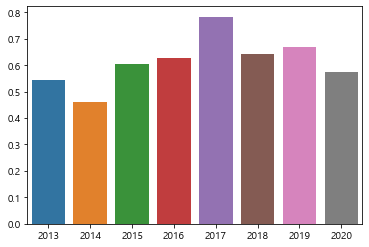

In [53]:
sns.barplot(data = pd.DataFrame(부입dict,index=['corr']))

    2)정시기준 연관성 비교

In [54]:
부입dict={}
for i in range(2013,2021) :
    부입dict[i] = pd.merge(df[['자치구',str(i)+'매매가']],df1[['자치구',str(i)+'(정시)']],  
                         on='자치구',how='outer').corr().iloc[0,1]   # 총합에서 정시로 변경

In [55]:
np.mean(list(부입dict.values()))

0.7863664039536427

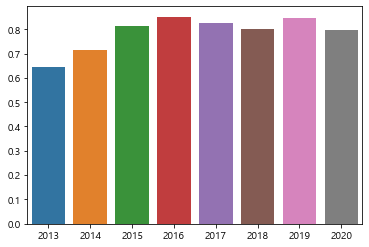

In [56]:
sns.barplot(data = pd.DataFrame(부입dict,index=['corr']))

    3)수시기준 연관성 비교

In [57]:
부입dict={}   # key = 연도 / values = corr값
for i in range(2013,2021) :
    부입dict[i] = pd.merge(df[['자치구',str(i)+'매매가']],df1[['자치구',str(i)+'(수시)']],on='자치구',how='outer').corr().iloc[0,1]

In [58]:
부입dict[i] = pd.merge(df[['자치구',str(i)+'매매가']],df1[['자치구',str(i)+'(수시)']],on='자치구',how='outer').corr().iloc[0,1]

In [59]:
np.mean(list(부입dict.values()))

0.32428044650742904

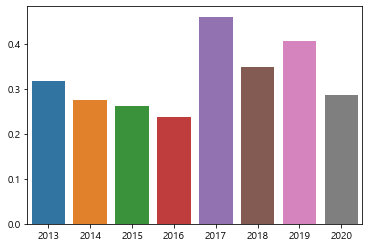

In [60]:
sns.barplot(data = pd.DataFrame(부입dict,index=['corr']))

## 입시자 & 학원 연관성 비교
    1) 수시+정시

In [61]:
학입dict={}   # key = 연도 / values = corr값
for i in range(2013,2019) :
    학입dict[i] = pd.merge(df[['자치구',str(i)+'사업체수']],df1[['자치구',str(i)+'(총합)']],on='자치구',how='outer').corr().iloc[0,1]

In [62]:
np.mean(list(학입dict.values()))

0.5470849715412148

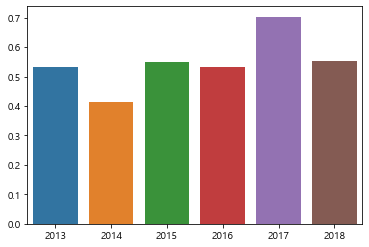

In [63]:
sns.barplot(data = pd.DataFrame(학입dict,index=['corr']))

    2) 정시기준

In [64]:
학입dict={}   # key = 연도 / values = corr값
for i in range(2013,2019) :
    학입dict[i] = pd.merge(df[['자치구',str(i)+'사업체수']],df1[['자치구',str(i)+'(정시)']],on='자치구',how='outer').corr().iloc[0,1]

In [65]:
np.mean(list(학입dict.values()))

0.6239322940408426

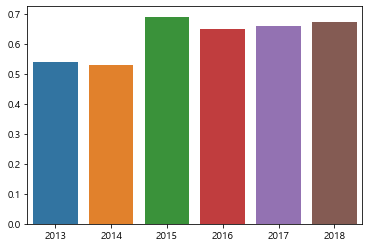

In [66]:
sns.barplot(data = pd.DataFrame(학입dict,index=['corr']))

    3) 수시기준

In [67]:
학입dict={}   # key = 연도 / values = corr값
for i in range(2013,2019) :
    학입dict[i] = pd.merge(df[['자치구',str(i)+'사업체수']],df1[['자치구',str(i)+'(수시)']],on='자치구',how='outer').corr().iloc[0,1]

In [68]:
np.mean(list(학입dict.values()))

0.333938159556294

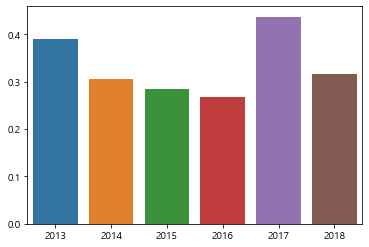

In [69]:
sns.barplot(data = pd.DataFrame(학입dict,index=['corr']))

## 학원 연관성 & 부동산 비교

In [70]:
학부dict={}
for i in range(2013,2019):
    학부dict[i] = df[[str(i)+'사업체수',str(i)+'매매가']].corr().iloc[0,1]

In [71]:
np.mean(list(학부dict.values()))

0.6037950590931674

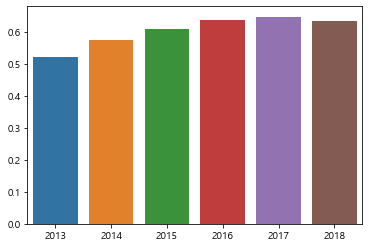

In [72]:
sns.barplot(data = pd.DataFrame(학부dict,index=['corr']))

### 부동산 월별 학원수와의 연관성 분석 

In [73]:
mon(12).loc[:,['2013사업체수','2013매매가']].corr().iloc[0,1]

0.5459317073267694

In [74]:
월별dict= {}
for i in range(1,13):
    임시 = []
    for j in range(2013,2019):
        임시.append(mon(i).loc[:,[str(j)+'사업체수',str(j)+'매매가']].corr().iloc[0,1])
        
    월별dict[i] =  np.mean(임시)   

In [75]:
월별dict   # 9,10, 11월이 가장 연관성이 높음

{1: 0.6037950590931674,
 2: 0.6044056403782277,
 3: 0.6057439016708747,
 4: 0.6080191243836764,
 5: 0.609268678322994,
 6: 0.6101657238787666,
 7: 0.6126829886954159,
 8: 0.6135462040085906,
 9: 0.6164607346864465,
 10: 0.6185927906974733,
 11: 0.6184641803777092,
 12: 0.6115359816693458}

In [76]:
np.mean(list(월별dict.values()))

0.6110567506552241

Text(0.5, 0, '월별')

<Figure size 288x216 with 0 Axes>

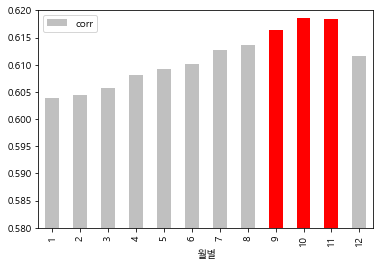

In [77]:
plt.figure(figsize = (4,3))
colors = ['silver','silver','silver','silver', 'silver', 'silver', 'silver', 'silver','Red','Red','Red','silver']

pd.DataFrame(월별dict,index=['corr']).T.plot.bar(y='corr' , color = colors)
plt.ylim([0.58, 0.62])

plt.xlabel('월별')

### 부동산 월별 학원수와의 연관성 분석 

In [78]:
mon(1).head(1)

,자치구,2013사업체수,2013종사자수,2014사업체수,2014종사자수,2015사업체수,2015종사자수,2016사업체수,2016종사자수,2017사업체수,2017종사자수,2018사업체수,2018종사자수,2013매매가,2014매매가,2015매매가,2016매매가,2017매매가,2018매매가,2019매매가
0,종로구,866,12325,885,12303,876,13646,880,13130,852,13317,850,13504,499805,479337,481884,504337,513023,602125,710411


In [79]:
mon(1).iloc[:,[0,-7,-6,-5,-4,-3,-2,-1]]   # 자치구 / 1월부동산가격

,자치구,2013매매가,2014매매가,2015매매가,2016매매가,2017매매가,2018매매가,2019매매가
0,종로구,499805,479337,481884,504337,513023,602125,710411
1,중구,493920,502759,509648,545037,554130,623017,775667
2,용산구,807000,761439,750030,791288,813773,1080385,1378500
3,성동구,439910,447987,456859,492987,503218,680771,881926
4,광진구,630606,600879,608515,654955,668409,765921,902974
5,동대문구,356423,349817,354500,389744,398415,447890,593904
6,중랑구,300176,296329,297434,312566,315100,353115,444432
7,성북구,369468,362592,365092,395602,407439,447027,558217
8,강북구,323917,318317,321167,346317,346422,385643,478758
9,도봉구,291208,285635,289167,307792,313396,350782,431198


In [80]:
인 = []
for i in range(2013,2021):
    인.append(str(i)+'(정시)')
인.append('자치구')

In [81]:
df1.loc[:,인]

,2013(정시),2014(정시),2015(정시),2016(정시),2017(정시),2018(정시),2019(정시),2020(정시),자치구
"시,구",,,,,,,,,
종로구,5.0,5.0,8.0,10.0,17.0,8.0,11.0,3.0,종로구
중구,4.0,7.0,10.0,15.0,29.0,20.0,18.0,11.0,중구
용산구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,용산구
성동구,3.0,3.0,3.0,3.0,4.0,2.0,4.0,1.0,성동구
광진구,44.0,32.0,31.0,30.0,13.0,14.0,20.0,23.0,광진구
동대문구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,동대문구
중랑구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,중랑구
성북구,10.0,8.0,4.0,6.0,4.0,1.0,1.0,1.0,성북구
강북구,2.0,3.0,2.0,0.0,2.0,5.0,5.0,3.0,강북구


In [82]:
판총 = pd.merge(mon(1).iloc[:,[0,-8,-7,-6,-5,-4,-3,-2,-1]],df1.loc[:,인],on='자치구',how = 'outer')
판총.head(2)

,자치구,2018종사자수,2013매매가,2014매매가,2015매매가,2016매매가,2017매매가,2018매매가,2019매매가,2013(정시),2014(정시),2015(정시),2016(정시),2017(정시),2018(정시),2019(정시),2020(정시)
0,종로구,13504,499805,479337,481884,504337,513023,602125,710411,5.0,5.0,8.0,10.0,17.0,8.0,11.0,3.0
1,중구,8321,493920,502759,509648,545037,554130,623017,775667,4.0,7.0,10.0,15.0,29.0,20.0,18.0,11.0


In [83]:
월별1dict = {}
for j in range(1,13):
    임시 = []
    판총 = pd.merge(mon(j).iloc[:,[0,-8,-7,-6,-5,-4,-3,-2,-1]],df1.loc[:,인],on='자치구',how = 'outer')
    for i in range(2013,2020):
        임시.append(판총.loc[:,[str(i)+'매매가',str(i)+'(정시)']].corr().iloc[0,1])
    월별1dict[j] = np.mean(임시)

In [84]:
np.mean(list(월별1dict.values()))  # 1월의 매매가가 가장 큰영향  #  7,8,9,11

0.7849597196409729

Text(0.5, 0, '월별')

<Figure size 288x216 with 0 Axes>

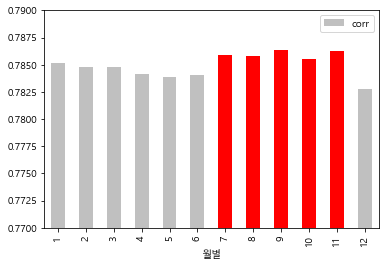

In [85]:
plt.figure(figsize = (4,3))
colors = ['silver','silver','silver','silver', 'silver', 'silver', 'Red', 'Red','Red','Red' ,'Red','silver']

pd.DataFrame(월별1dict,index=['corr']).T.plot.bar(y='corr' , color = colors)
plt.ylim([0.77, 0.79])

plt.xlabel('월별')

## (+) 시각화

### 입시생 & 매매가 관계

In [86]:
mon(9).shape

(25, 20)

In [87]:
list(range(13,21))

[13, 14, 15, 16, 17, 18, 19, 20]

In [88]:
df부 = mon(9).iloc[:,[0,13, 14, 15, 16, 17, 18, 19]]
df부

,자치구,2013매매가,2014매매가,2015매매가,2016매매가,2017매매가,2018매매가,2019매매가
0,종로구,495207,479093,501791,509012,524488,637167,711357
1,중구,485120,504833,538519,550778,566111,682467,771567
2,용산구,772379,748606,787015,804015,838864,1172949,1368579
3,성동구,434000,455346,483500,497641,517038,726677,867574
4,광진구,601015,602409,641409,658848,685682,803842,899434
5,동대문구,347718,352902,378963,394049,407024,476320,586223
6,중랑구,297595,296816,305211,313325,319063,366052,442989
7,성북구,356309,363694,388122,401898,412469,482518,555113
8,강북구,317133,319300,339800,344125,350547,412929,480848
9,도봉구,281552,286979,302594,310531,319302,365191,427491


In [89]:
l = []
for i in range(2013,2021):
    l.append(str(i)+'(정시)')

In [90]:
df1
l.append('자치구')

In [102]:
df학 = df1.loc[:,l]
df학.reindex()
df학

,2013(정시),2014(정시),2015(정시),2016(정시),2017(정시),2018(정시),2019(정시),2020(정시),자치구
"시,구",,,,,,,,,
종로구,5.0,5.0,8.0,10.0,17.0,8.0,11.0,3.0,종로구
중구,4.0,7.0,10.0,15.0,29.0,20.0,18.0,11.0,중구
용산구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,용산구
성동구,3.0,3.0,3.0,3.0,4.0,2.0,4.0,1.0,성동구
광진구,44.0,32.0,31.0,30.0,13.0,14.0,20.0,23.0,광진구
동대문구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,동대문구
중랑구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,중랑구
성북구,10.0,8.0,4.0,6.0,4.0,1.0,1.0,1.0,성북구
강북구,2.0,3.0,2.0,0.0,2.0,5.0,5.0,3.0,강북구


In [92]:
df부동학생 = pd.merge(df부,df학,on = '자치구',how ='outer')
df부동학생 = df부동학생.dropna(0)
df부동학생

,자치구,2013매매가,2014매매가,2015매매가,2016매매가,2017매매가,2018매매가,2019매매가,2013(정시),2014(정시),2015(정시),2016(정시),2017(정시),2018(정시),2019(정시),2020(정시)
0,종로구,495207,479093,501791,509012,524488,637167,711357,5.0,5.0,8.0,10.0,17.0,8.0,11.0,3.0
1,중구,485120,504833,538519,550778,566111,682467,771567,4.0,7.0,10.0,15.0,29.0,20.0,18.0,11.0
3,성동구,434000,455346,483500,497641,517038,726677,867574,3.0,3.0,3.0,3.0,4.0,2.0,4.0,1.0
4,광진구,601015,602409,641409,658848,685682,803842,899434,44.0,32.0,31.0,30.0,13.0,14.0,20.0,23.0
7,성북구,356309,363694,388122,401898,412469,482518,555113,10.0,8.0,4.0,6.0,4.0,1.0,1.0,1.0
8,강북구,317133,319300,339800,344125,350547,412929,480848,2.0,3.0,2.0,0.0,2.0,5.0,5.0,3.0
9,도봉구,281552,286979,302594,310531,319302,365191,427491,2.0,5.0,8.0,10.0,11.0,9.0,9.0,9.0
10,노원구,263162,270768,297190,304662,317746,374400,443195,5.0,2.0,7.0,9.0,11.0,6.0,10.0,1.0
11,은평구,337243,353300,372125,382725,397200,463311,534337,3.0,10.0,9.0,9.0,8.0,5.0,4.0,11.0
12,서대문구,354286,362271,375414,387743,400714,518830,608571,1.0,0.0,4.0,3.0,3.0,4.0,0.0,1.0


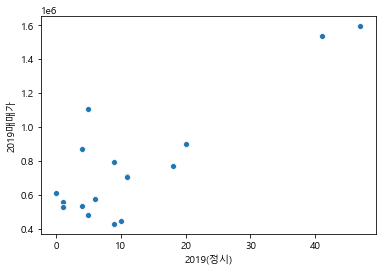

In [101]:
sns.scatterplot(data=df부동학생, x='2019(정시)', y='2019매매가')

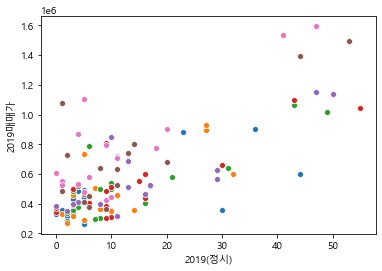

In [99]:
for i in range(2013, 2020) :
    sns.scatterplot(data=df부동학생, x=str(i)+'(정시)', y=str(i)+'매매가')

In [94]:
df부동학생['매매가'] = df부동학생['2013매매가']+df부동학생['2014매매가']+df부동학생['2015매매가']+df부동학생['2016매매가']+df부동학생['2017매매가']+df부동학생['2018매매가']+df부동학생['2019매매가']
df부동학생['입학생'] = df부동학생['2013(정시)']+df부동학생['2014(정시)']+df부동학생['2015(정시)']+df부동학생['2016(정시)']+df부동학생['2017(정시)']+df부동학생['2018(정시)']+df부동학생['2019(정시)']

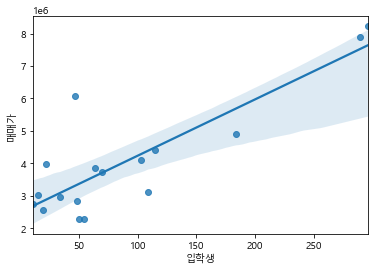

In [95]:
sns.regplot(data=df부동학생, x='입학생', y='매매가')

### 입시생 & 학원수 

In [105]:
df학  # 입시생(정시기준)

,2013(정시),2014(정시),2015(정시),2016(정시),2017(정시),2018(정시),2019(정시),2020(정시),자치구
"시,구",,,,,,,,,
종로구,5.0,5.0,8.0,10.0,17.0,8.0,11.0,3.0,종로구
중구,4.0,7.0,10.0,15.0,29.0,20.0,18.0,11.0,중구
용산구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,용산구
성동구,3.0,3.0,3.0,3.0,4.0,2.0,4.0,1.0,성동구
광진구,44.0,32.0,31.0,30.0,13.0,14.0,20.0,23.0,광진구
동대문구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,동대문구
중랑구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,중랑구
성북구,10.0,8.0,4.0,6.0,4.0,1.0,1.0,1.0,성북구
강북구,2.0,3.0,2.0,0.0,2.0,5.0,5.0,3.0,강북구


In [109]:
df원 = mon(10).iloc[:,[0,1,3,5,7,9,11]]  # 학원사업체수
df원

,자치구,2013사업체수,2014사업체수,2015사업체수,2016사업체수,2017사업체수,2018사업체수
0,종로구,866,885,876,880,852,850
1,중구,510,516,508,481,454,471
2,용산구,509,527,541,539,539,550
3,성동구,745,760,785,810,886,961
4,광진구,1132,1114,1100,1136,1159,1183
5,동대문구,925,934,945,959,985,1000
6,중랑구,898,926,880,911,922,936
7,성북구,1304,1304,1302,1337,1372,1382
8,강북구,701,709,662,685,683,684
9,도봉구,975,958,942,931,960,962


In [114]:
df학원입시 = pd.merge(df학,df원,on='자치구',how = 'outer')
df학원입시 = df학원입시.dropna()
df학원입시

,2013(정시),2014(정시),2015(정시),2016(정시),2017(정시),2018(정시),2019(정시),2020(정시),자치구,2013사업체수,2014사업체수,2015사업체수,2016사업체수,2017사업체수,2018사업체수
0,5.0,5.0,8.0,10.0,17.0,8.0,11.0,3.0,종로구,866,885,876,880,852,850
1,4.0,7.0,10.0,15.0,29.0,20.0,18.0,11.0,중구,510,516,508,481,454,471
3,3.0,3.0,3.0,3.0,4.0,2.0,4.0,1.0,성동구,745,760,785,810,886,961
4,44.0,32.0,31.0,30.0,13.0,14.0,20.0,23.0,광진구,1132,1114,1100,1136,1159,1183
7,10.0,8.0,4.0,6.0,4.0,1.0,1.0,1.0,성북구,1304,1304,1302,1337,1372,1382
8,2.0,3.0,2.0,0.0,2.0,5.0,5.0,3.0,강북구,701,709,662,685,683,684
9,2.0,5.0,8.0,10.0,11.0,9.0,9.0,9.0,도봉구,975,958,942,931,960,962
10,5.0,2.0,7.0,9.0,11.0,6.0,10.0,1.0,노원구,1810,1835,1880,1903,1951,1950
11,3.0,10.0,9.0,9.0,8.0,5.0,4.0,11.0,은평구,1402,1433,1415,1405,1430,1469
12,1.0,0.0,4.0,3.0,3.0,4.0,0.0,1.0,서대문구,1023,1008,1021,1040,1078,1086


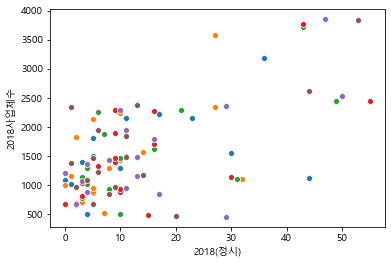

In [115]:
for i in range(2013, 2019) :
    sns.scatterplot(data=df학원입시, x=str(i)+'(정시)', y=str(i)+'사업체수')